# Pytorch example

This file shows a minimal pytorch example running on adult data, and demonstrating head-merging.

In general, we strongly recommend that you *do not* use neural networks on tabular data. Boosting is typically higher performing and much faster to run.

However, this is a toy example, and unlike computer vision examples, it should train and run in a matter of minutes. The techniques shown will directly apply to computer vision and NLP without modification.

In [1]:
# Load libraries

import oxonfair
from oxonfair import group_metrics as gm

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim


In [2]:
#Load adult dataset, using sex as the default groups and discard sex from the raw data
train, val, test = oxonfair.dataset_loader.adult(discard_groups=True)

In [3]:
#Normalise data
std = train['data'].std()
train['data'] = train['data'] / std
val['data'] = val['data'] / std
test['data'] = test['data'] / std

In [4]:
#define a basic nn with 2 hiden-layers. 1 of width 100, and the second width 50.
network = nn.Sequential(nn.Linear(train['data'].shape[1],100),
                        nn.SELU(),
                        nn.Linear(100,50),
                        nn.SELU(),
                        nn.Linear(50,2))

In [5]:
# Define a custom loss that trains the two-heads as required.
def loss(x, y, g):
    output = network(x)
    loss0 = F.binary_cross_entropy_with_logits(output[:,0], y)
    loss1 = F.mse_loss(output[:,1], g)
    return loss0+loss1

In [6]:
# Copy variables to tensors
target = torch.tensor(train['target']).float()
data = torch.tensor(np.asarray(train['data'])).float()
groups = torch.tensor(train['groups']==' Male').float()

optimizer = optim.Adam(network.parameters(), lr=1e-4)
from numpy import random

In [7]:
# Train the network
batch_size = 100

for epoch in range(50):
    #shuffle data
    perm = random.permutation(target.shape[0])
    target = target[perm]
    data = data[perm]
    groups = groups[perm]
    if epoch%10==0:
        print ('epoch is %d'%epoch)
    for step in range(target.shape[0]//batch_size): # This discards the final incomplete batch
        optimizer.zero_grad()
        l = loss(data[step*batch_size:(1+step)*batch_size],
                 target[step*batch_size:(1+step)*batch_size],
                 groups[step*batch_size:(1+step)*batch_size])
        l.backward()
        optimizer.step()

epoch is 0
epoch is 10
epoch is 20
epoch is 30
epoch is 40


In [8]:
#convert test['data'] to tensor via numpy and then move the output back to numpy
test_output=np.asarray(network(torch.tensor(np.asarray(test['data'])).float()).detach())

To see if training works we visualize the outputs of the second head (corresponding to gender)

Ideally, this should be a two peaked distribution centered on 0 and 1, with more values at 1 -- corresponding to the male label.

Instead, we find we have 1 peak centered on 1, a broader central peak corresponding to 'don't know' centered around 0.5 and a third smaller peak around 0.2 and 0.

This is fine. The broad central peak reflects the ambiguity of the task, and otherwise we do have something of a split into male and female.

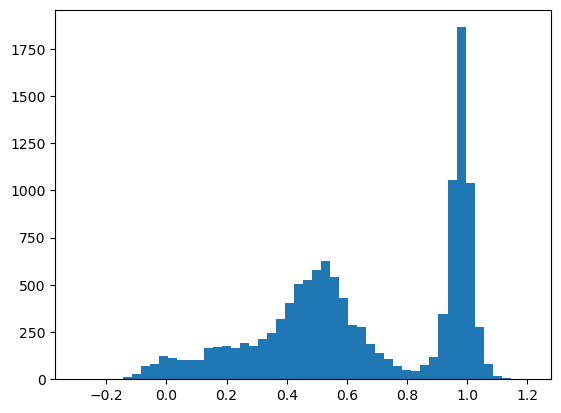

In [9]:
#Plot the outputs of the second head
from matplotlib import pyplot as plt
_=plt.hist(test_output[:,1],bins=50)

In [10]:
#Let's train a fair classifier using the two heads 
#convert val['data'] to tensor via numpy and then move the output back to numpy
val_output = np.asarray(network(torch.tensor(np.asarray(val['data'])).float()).detach())



In [37]:
fpred = oxonfair.DeepFairPredictor(val['target'],
                                   val_output,
                                   groups=val['groups'])
# Enforce fairness on validation data -- i.e. demographic/statistical parity should be within 2 %
fpred.fit(gm.accuracy, gm.demographic_parity, 0.02,grid_width=75)
# Varying the grid with can improve accuracy at the cost of a longer search time.

In [38]:
# Check performance drop
fpred.evaluate()

,original,updated
Accuracy,0.847830,0.831122
Balanced Accuracy,0.762406,0.721869
F1 score,0.653099,0.592168
MCC,0.560485,0.498524
Precision,0.718570,0.701500
Recall,0.598563,0.512320
ROC AUC,0.898272,0.874854


In [13]:
# and fairness
fpred.evaluate_fairness()

,original,updated
Statistical Parity,0.198062,0.017746
Predictive Parity,0.027956,0.224696
Equal Opportunity,0.205310,0.268446
Average Group Difference in False Negative Rate,0.205310,0.268446
Equalized Odds,0.144108,0.143545
Conditional Use Accuracy,0.056734,0.201382
Average Group Difference in Accuracy,0.102731,0.133009
Treatment Equality,0.330283,0.881673


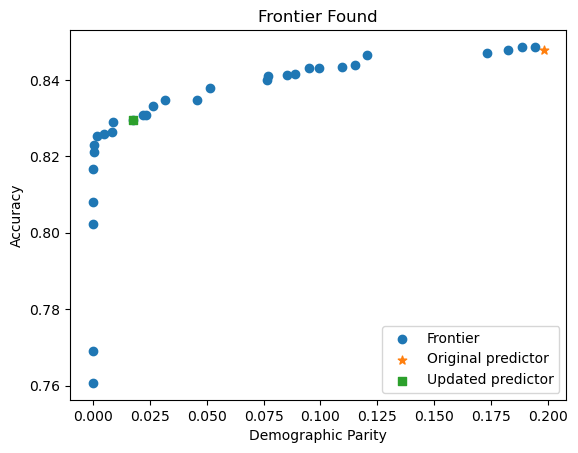

In [14]:
#Visualise the possible trade-offs
fpred.plot_frontier()

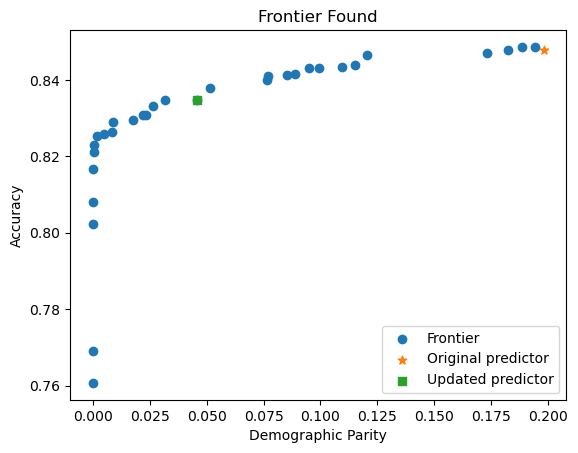

In [15]:
#To quickly select another point from the frontier, you can call it with recompute=False
fpred.fit(gm.accuracy, gm.demographic_parity, 0.05, recompute=False)
fpred.plot_frontier()


In [16]:
# to evaluate how it's working on the test set, we'll create a new dataset holder
test_network = oxonfair.DeepDataDict(test['target'], test_output, test['groups'])

In [17]:
#And evaluate
fpred.evaluate(test_network)

,original,updated
Accuracy,0.843092,0.835312
Balanced Accuracy,0.756238,0.694122
F1 score,0.642671,0.551616
MCC,0.546807,0.495812
Precision,0.706148,0.791427
Recall,0.589665,0.423340
ROC AUC,0.898294,0.888081


In [18]:
fpred.evaluate_fairness()

,original,updated
Statistical Parity,0.198062,0.045901
Predictive Parity,0.027956,0.187650
Equal Opportunity,0.205310,0.180463
Average Group Difference in False Negative Rate,0.205310,0.180463
Equalized Odds,0.144108,0.092642
Conditional Use Accuracy,0.056734,0.175476
Average Group Difference in Accuracy,0.102731,0.127016
Treatment Equality,0.330283,0.595324


In [19]:
# Now let's merge the heads
# We examine the coefficients first.
fpred.extract_coefficients()

(-1.692, 0.7363)

The block below shows the merging step for two groups. 

When only two groups exist, we are using a binary encoding of groups and trying to predict either 0 or 1.
The parameters we learn correspond to a scalar `a`, and bias `b`, and the predictions made by the merging:

    classification_head + a * group_head +b

should be fair and performant.

When more than two groups exist, you should have trained the second head to output a one-hot encoding of the groups and the merging:

    classification_head + a.dot(group_head)

should be fair and performant.

In [20]:
# We copy the network and create a fair version
import copy
fair_network= copy.deepcopy(network)
# We replace the final linear layer with a 1 dimensional head.
fair_network[4]=nn.Linear(50,1)
#Now we merge the weights 
fair_network[4].weight.data[:] = (network[4].weight[0] + fpred.extract_coefficients()[0]*network[4].weight[1]).data
# and the biases
fair_network[4].bias.data[:] = (network[4].bias[0] + fpred.extract_coefficients()[0]*network[4].bias[1]).data
# and add the extra bias term
fair_network[4].bias.data += fpred.extract_coefficients()[1]


In [21]:
# Now let's check the fair classifier on the test set.
test_fair_output=np.asarray(fair_network(torch.tensor(np.asarray(test['data'])).float()).detach())

In [22]:
# As expected the accuracy is identical to what was reported before.

oxonfair.performance.evaluate(test['target'],test_fair_output.reshape(-1))

,0
Accuracy,0.835312
Balanced Accuracy,0.694122
F1 score,0.551616
MCC,0.495812
Precision,0.791427
Recall,0.423340
ROC AUC,0.888081


In [23]:
# And so is the fairness
oxonfair.performance.evaluate_fairness(test['target'],test_fair_output.reshape(-1),test['groups'])

,0
Statistical Parity,0.042919
Predictive Parity,0.208145
Equal Opportunity,0.183621
Average Group Difference in False Negative Rate,0.183621
Equalized Odds,0.096218
Conditional Use Accuracy,0.185606
Average Group Difference in Accuracy,0.123668
Treatment Equality,0.664866


In [24]:
# Finally, let's compare to a range of other oxonfair based classifiers.
# These don't support head merging
# 1. The base method that just picks the most likely group label instead of keeping track of the value returned 
fpred_standard = oxonfair.DeepFairPredictor(val['target'],
                                              val_output,
                                              groups=val['groups'], use_fast=True)
# 2. A classifier that enforces fairness by using the actual group labels instead of inferred.
fpred_true_groups = oxonfair.DeepFairPredictor(val['target'],
                                              val_output,
                                              groups=val['groups'], use_fast=True,use_actual_groups=True)


# 3. Single threshold. This adjusts the global bias only, without considering group membership.
# It works surprisingly well for criteria like recall.min, but is less useful for fairness
fpred_thresh  = oxonfair.DeepFairPredictor(val['target'],
                                              val_output,
                                              groups=val['groups'], use_actual_groups='single_threshold')


In [25]:
fpred_standard.inferred_groups, fpred_true_groups.inferred_groups

(<function oxonfair.learners.fair.DeepFairPredictor.<locals>.square_align(array)>,
 False)

In [26]:
fpred_standard.fit(gm.accuracy,gm.demographic_parity,0.05)
fpred_true_groups.fit(gm.accuracy,gm.demographic_parity,0.05)
fpred_thresh.fit(gm.accuracy,gm.demographic_parity,0.05)



Fewer groups used (1) in infered groups than in the true groups (2)


(0.75, 0.8534766584766584)

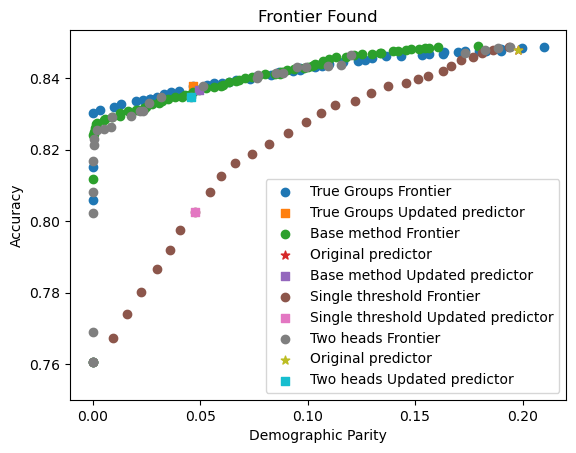

In [27]:
# Plot of curves on validation data
# This shows that the first three approaches are basically interchangable
fpred_true_groups.plot_frontier(prefix='True Groups ', new_plot=False, show_original=False)
fpred_standard.plot_frontier(prefix='Base method ', new_plot=False)
fpred_thresh.plot_frontier(prefix='Single threshold ', new_plot=False, show_original=False)
fpred.plot_frontier(prefix='Two heads ', new_plot=False)
plt.ylim(bottom=0.75)

In [28]:
test

{'target': array([False,  True,  True, ..., False, False, False]),
 'data':            age  workclass    fnlwgt  education  education-num  marital-status  \
 0     0.582314   2.725317  1.705921   2.327221       4.691393        2.647410   
 5     2.474835   2.725317  1.699130   3.878702       3.518545        1.323705   
 11    1.746942   2.725317  1.942097   3.102962       5.082342        1.323705   
 15    1.965310   1.362659  0.640617   1.810061       4.300444        1.323705   
 24    2.183678   2.725317  2.809205   3.878702       3.518545        1.323705   
 ...        ...        ...       ...        ...            ...             ...   
 9751  0.218368   2.725317  1.685045   2.844382       3.127595        2.647410   
 9757  0.363946   2.725317  0.385703   3.878702       3.518545        2.647410   
 9759  3.057149   4.087976  1.767921   2.585802       5.864241        1.323705   
 9763  4.367355   2.725317  1.274945   2.327221       4.691393        2.647410   
 9764  1.382996   2.725